# embeddings

> Fill in a module description here

In [ ]:
#| default_exp embeddings

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import json

import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from fastai.vision.all import *

from singleline_stroke3.fileorg import *

## Load Pretrained Model

Loading a dataset of raster images from a directory containing sketchbook folders.

In [ ]:
#| export
DEFAULT_DATA_HOME = singleline_data_home('../data_home')
PRETRAINED_MODEL_PATH = "models/epoch-20231128/01_FLAT"
PRETRAINED_CHECKPOINT = "model_20231121_2epochs"
#LATEST_MODEL = (PRETRAINED_DATA_ROOT, PRETRAINED_CHECKPOINT)

def load_resnet(data_home=DEFAULT_DATA_HOME, model_path=PRETRAINED_MODEL_PATH, model_checkpoint=PRETRAINED_CHECKPOINT):
    model_data_root = data_home / model_path
    
    # dummy dataloader with the right number of target classes,
    # so that the learner has the correct number of output neurons to load the model weights.
    dls2 = ImageDataLoaders.from_path_func(
        model_data_root,
        get_image_files(model_data_root),
        lambda p: os.path.basename(os.path.dirname(p)),
        item_tfms=Resize(224),
        seed=42,
        shuffle=False,
        valid_pct=0.0,
    )
    learn = vision_learner(dls2, resnet34, metrics=error_rate)
    learn.load(model_checkpoint)

    return learn

no env var SINGLELINE_DATA_HOME, defaulting to: None


In [ ]:
learn = load_resnet()
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=5, bias=False)
)

Path('../data_home/raster/epoch-20231214/01_FLAT/art/sb45p077.jpg')

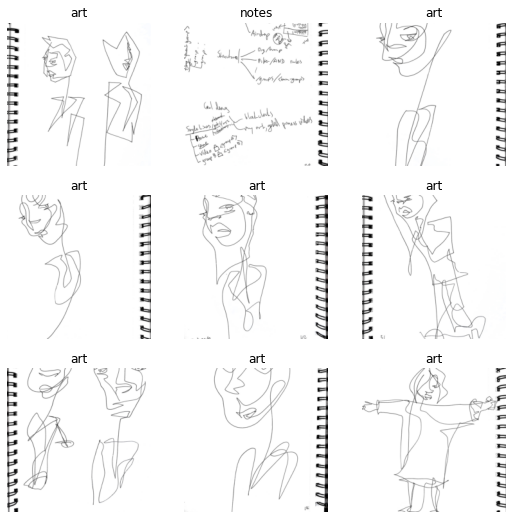

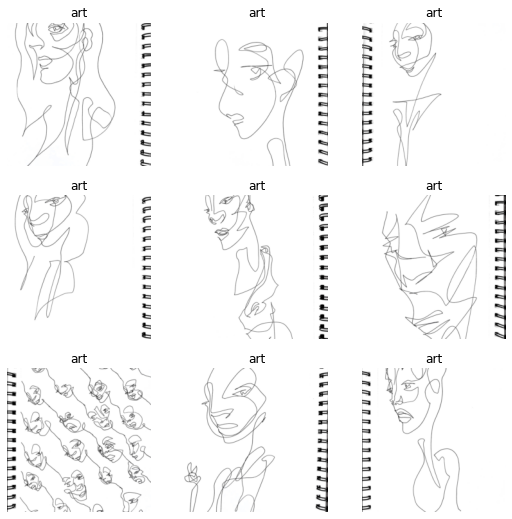

In [ ]:
dls.valid.show_batch(max_n=9, ncols=3)

## Creating batches from sketchbook directory

In [ ]:
#| export
DEFAULT_BATCH_SIZE = 64

def sketchbook_dataloaders(sketchbooks_dir, **kwargs):
    """ Loads image data and label based on parent folder - minimum data needed to train CNN """
    path = Path(sketchbooks_dir)

    files = get_image_files(path)

    path_func = lambda p: os.path.basename(os.path.dirname(p))

    dataloaders = ImageDataLoaders.from_path_func(
        path,
        files,
        path_func,
        item_tfms=Resize(224),
        batch_size=DEFAULT_BATCH_SIZE,
        **kwargs
    )
    return dataloaders


In [ ]:
# #| hide

# """ code to train original model """

# # dataloaders = sketchbook_dataloaders(sample_path / "01_FLAT")
# # print(dataloaders.vocab)
# # learn = vision_learner(dataloaders, resnet34, metrics=error_rate)
# # learn = sketchbook_resnet34(SAMPLE_SKETCHBOOKS_DIR)
# # learn.fine_tune(6)
# # learn.recorder.plot_loss()
# # learn.save("SAMPLE_CHECKPOINT")

no env var SINGLELINE_DATA_HOME, defaulting to: None
../data_home/raster/epoch-20231214/01_FLAT/notes/sb44p028.jpg


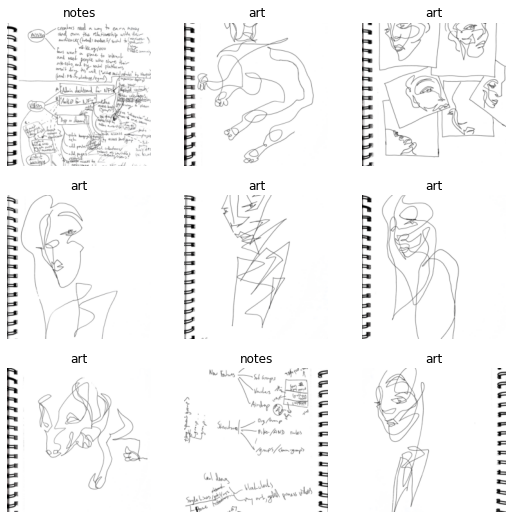

In [ ]:
data_home = singleline_data_home(default="../data_home")
sample_path = data_home / "raster/epoch-20231214/01_FLAT"
dls = sketchbook_dataloaders(sample_path)
test_eq(["art", "cover", "notes"], dls.vocab)
print(dls.items[0])
dls.train.show_batch(max_n=9, ncols=3)

In [ ]:
#| export
def batch_fnames_and_images(sketchbooks_dir):
    """
    Prepare data to compute embeddings over all images and store
    them along with a reference to the underlying filename.
    """
    ordered_dls = sketchbook_dataloaders(
        sketchbooks_dir, seed=42, shuffle=False, valid_pct=0.0
    )

    # compute the number of batches
    num_batches = math.ceil(len(ordered_dls.train.items) / DEFAULT_BATCH_SIZE)
    assert num_batches == len(ordered_dls.train)
    batched_fnames = [
        ordered_dls.train.items[i * 64 : (i + 1) * 64] for i in range(num_batches)
    ]
    print(
        f"total items: {len(ordered_dls.train.items)}, num batches: {len(batched_fnames)}"
    )
    return batched_fnames, ordered_dls

In [ ]:
batched_fnames, ordered_dls = batch_fnames_and_images(sample_path)

# ensure all items are in train, none in valid
test_eq(0, len(ordered_dls.valid.items))
test_eq(len(ordered_dls.items), len(ordered_dls.train.items))

# ensure there are the same number of batches
test_eq(len(batched_fnames), len(ordered_dls.train))
test_eq(DEFAULT_BATCH_SIZE, len(batched_fnames[0]))

total items: 246, num batches: 4


In [ ]:
#| hide

## To debug input data, torchvision transform turns tensor back into PIL Image.

# import torchvision.transforms as T
# xform = T.ToPILImage()
# img = xform(x0.squeeze(0))

## Extracting Embeddings

In [ ]:
#| export
def predict_embeddings(model, xb):
    # import pdb
    # pdb.set_trace()
    with torch.no_grad():
        with Hook(model[-1][-2]) as hook:
            output = model.to("cpu").eval()(xb.to("cpu"))
            act = hook.stored
    return act.cpu().numpy()


class Hook:
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)

    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.hook.remove()

In [ ]:
train_iter = iter(ordered_dls.train)
x0, y0 = next(train_iter)
print(x0.shape, y0.shape)

activations = predict_embeddings(learn.model, x0)
activations.shape

torch.Size([64, 3, 224, 224]) torch.Size([64])


(64, 512)

## Bulk-computing embeddings

In [ ]:
#| export
def embed_dir(input_dir, learner, strip_dir=None):
    """
    Get images paired with their filenames, grouped into batches.
    Compute embeddings and yield JSON records including embedding + filename,
    so the data can be stored for downstream processes that need embeddings
    mapped to specific files (ex. clustering/visual search and taking some
    action like moving files based on the results).
    """
    batched_fnames, ordered_dls = batch_fnames_and_images(input_dir)
    with torch.no_grad(), learner.no_logging():
        for i, batch in enumerate(zip(batched_fnames, ordered_dls.train)):
            batched_fnames, (x, y) = batch
            bs = len(batched_fnames)
            assert bs == x.shape[0]
            assert bs == y.shape[0]

            activations = predict_embeddings(learner.model, x)
            assert bs == activations.shape[0]

            for j in range(bs):
                y_j = y[j]
                fname_j = batched_fnames[j]
                if strip_dir:
                    fname_j = str(fname_j).replace(f"{strip_dir}/", "")
                emb_j = activations[j]
                # label: what parent dir exists in the dataset we're processing
                label_j = ordered_dls.vocab[y_j]
                # # pred_label: prediction made relative to the vocab of the learner's model
                # # (may be different than what's in the dataloader we're using for input).
                # x_j = x[j]
                # pred_label_j, pred_idx_j, pred_probs_j = learner.predict(x_j.cpu())
                yield {
                    "idx": j + i * bs,
                    "indiv_fname": os.path.basename(fname_j),
                    "orig_fname": fname_j,
                    "label": label_j,
                    # "pred_label": pred_label_j,
                    # "pred_idx": pred_idx_j.cpu().numpy(),
                    # "pred_probs": ",".join(
                    #     [f"{p:04f}" for p in pred_probs_j.cpu().numpy()]
                    # ),
                    "emb_csv": ",".join([str(f) for f in list(emb_j)]),
                }

In [ ]:
rows = []
for x in embed_dir(sample_path, learn):
    rows.append(x)
df = pd.DataFrame(rows)

total items: 246, num batches: 4


In [ ]:
df.head()

,indiv_fname,orig_fname,label,emb_csv
idx,,,,
0,sb44p049.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p049.jpg,art,"1.0963115,-0.1873892,-0.3412825,-0.6553513,1.0065825,-0.65341413,-0.7267234,0.025523007,-0.7537334,-0.3442595,-0.4671128,-0.72562873,-0.662768,-0.26702076,-0.25140375,0.72592056,0.7253965,-0.6520286,-0.21570086,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,0.20861775,-0.6690378,-0.4518578,0.6090119,2.2171075,-0.45211998,-0.68509877,-0.67007643,1.411777,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,1.1301389,1.239999,-0.61049384,-0.4847572,0.6425828,0.5909186,-0.75794554,-0.59257406,0.20541078,-0.6001429,-0.651804,0.30712163,0.021961749,-0.66552746,-0.6482407,-0.37303212,-..."
1,sb44p045.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p045.jpg,art,"2.5916977,0.5747772,-0.73929733,-0.6553513,0.87351775,-0.65341413,-0.2994294,1.6636466,-0.7537334,-0.42715576,0.09499085,-0.72562873,0.38449252,-0.6266761,0.38931924,1.1327198,-0.5467274,1.3437045,-0.6898426,-0.6497359,0.69656426,-0.55193967,0.14782143,-0.6779002,0.48844498,-0.6690378,-0.4518578,-0.5982413,-0.73986673,-0.45211998,-0.68509877,-0.67007643,0.97722983,-0.07580933,-0.600525,-0.6186755,-0.73933,-0.57338566,0.2527343,0.57011783,-0.61049384,0.78320307,3.4255471,-0.6682474,-0.75794554,-0.59257406,-0.6157326,-0.6001429,-0.651804,1.0960197,0.39430785,-0.66552746,0.90629435,-0.4732165..."
2,sb44p071.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p071.jpg,art,"0.8228437,0.3887819,-0.73929733,0.2188344,0.044190526,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,0.2847162,-0.72562873,-0.662768,-0.6266761,-0.21434084,2.0225072,-0.29906166,-0.64099866,-0.6898426,-0.6497359,-0.64108604,-0.55193967,0.28404534,-0.5659798,0.6158938,0.38389075,-0.4518578,-0.1076681,0.049622715,-0.45211998,-0.68509877,-0.047350645,0.47402424,-0.4592305,-0.600525,-0.6186755,0.40847105,-0.57338566,0.7490345,2.063302,-0.50217974,-0.58021957,-0.11689639,-0.6682474,-0.54299295,-0.59257406,0.13836902,-0.6001429,-0.651804,-0.42793423,-0.59497476,-0.66552746,-0.6482407,-..."
3,sb45p006.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb45p006.jpg,art,"2.991085,1.0507414,-0.73929733,-0.6553513,1.0344652,-0.65341413,1.9272916,-0.24077314,-0.7537334,0.28562954,1.6035789,-0.72562873,0.74390256,-0.6266761,-0.68991846,1.3627223,-0.5467274,-0.6520286,0.12740105,-0.49490267,-0.64108604,-0.55193967,0.50802034,-0.6779002,-0.57759243,-0.27610457,-0.4518578,-0.5982413,-0.73986673,-0.45211998,-0.68509877,0.47423834,0.3391884,-0.4592305,-0.600525,0.9713297,-0.73933,-0.57338566,1.0828016,1.6164833,-0.4634605,-0.5781493,-0.03461206,-0.6682474,-0.75794554,-0.59257406,-0.32803616,-0.6001429,-0.651804,0.09011638,1.452174,-0.66552746,-0.6482407,0.8101413,-..."
4,sb44p117.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p117.jpg,art,"2.651878,-0.47189847,-0.73929733,-0.06073433,1.7762058,-0.27124324,1.6564848,0.04661113,-0.7537334,-0.42715576,0.88455665,-0.72562873,2.2176247,-0.6266761,0.32795995,0.21997976,-0.5467274,-0.6520286,0.3414898,0.11300355,0.39495403,-0.55193967,-0.5446661,-0.6779002,0.80292994,-0.6690378,-0.4518578,-0.09538698,-0.73986673,-0.45211998,-0.68509877,-0.22862256,0.5013002,-0.1508924,-0.600525,-0.6186755,-0.73933,-0.57338566,0.54063046,0.26565653,-0.61049384,0.49002725,1.7332715,-0.6682474,-0.75794554,-0.59257406,0.9093066,0.1411075,0.30942822,-0.23874053,1.3506474,-0.66552746,2.9867826,-0.4732165..."


## De/Serialize Embeddings

In [ ]:
embeddings_fname = f"{str(sample_path)}.tsv"
df.to_csv(embeddings_fname, index=False, sep="\t", header=True)
print(f"wrote {embeddings_fname}")

wrote ../data_home/raster/epoch-20231214/01_FLAT.tsv


In [ ]:
df = pd.read_csv(embeddings_fname, delimiter="\t")
df.head()

,indiv_fname,orig_fname,label,emb_csv
0,sb44p049.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p049.jpg,art,"1.0963115,-0.1873892,-0.3412825,-0.6553513,1.0065825,-0.65341413,-0.7267234,0.025523007,-0.7537334,-0.3442595,-0.4671128,-0.72562873,-0.662768,-0.26702076,-0.25140375,0.72592056,0.7253965,-0.6520286,-0.21570086,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,0.20861775,-0.6690378,-0.4518578,0.6090119,2.2171075,-0.45211998,-0.68509877,-0.67007643,1.411777,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,1.1301389,1.239999,-0.61049384,-0.4847572,0.6425828,0.5909186,-0.75794554,-0.59257406,0.20541078,-0.6001429,-0.651804,0.30712163,0.021961749,-0.66552746,-0.6482407,-0.37303212,-..."
1,sb44p045.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p045.jpg,art,"2.5916977,0.5747772,-0.73929733,-0.6553513,0.87351775,-0.65341413,-0.2994294,1.6636466,-0.7537334,-0.42715576,0.09499085,-0.72562873,0.38449252,-0.6266761,0.38931924,1.1327198,-0.5467274,1.3437045,-0.6898426,-0.6497359,0.69656426,-0.55193967,0.14782143,-0.6779002,0.48844498,-0.6690378,-0.4518578,-0.5982413,-0.73986673,-0.45211998,-0.68509877,-0.67007643,0.97722983,-0.07580933,-0.600525,-0.6186755,-0.73933,-0.57338566,0.2527343,0.57011783,-0.61049384,0.78320307,3.4255471,-0.6682474,-0.75794554,-0.59257406,-0.6157326,-0.6001429,-0.651804,1.0960197,0.39430785,-0.66552746,0.90629435,-0.4732165..."
2,sb44p071.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p071.jpg,art,"0.8228437,0.3887819,-0.73929733,0.2188344,0.044190526,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,0.2847162,-0.72562873,-0.662768,-0.6266761,-0.21434084,2.0225072,-0.29906166,-0.64099866,-0.6898426,-0.6497359,-0.64108604,-0.55193967,0.28404534,-0.5659798,0.6158938,0.38389075,-0.4518578,-0.1076681,0.049622715,-0.45211998,-0.68509877,-0.047350645,0.47402424,-0.4592305,-0.600525,-0.6186755,0.40847105,-0.57338566,0.7490345,2.063302,-0.50217974,-0.58021957,-0.11689639,-0.6682474,-0.54299295,-0.59257406,0.13836902,-0.6001429,-0.651804,-0.42793423,-0.59497476,-0.66552746,-0.6482407,-..."
3,sb45p006.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb45p006.jpg,art,"2.991085,1.0507414,-0.73929733,-0.6553513,1.0344652,-0.65341413,1.9272916,-0.24077314,-0.7537334,0.28562954,1.6035789,-0.72562873,0.74390256,-0.6266761,-0.68991846,1.3627223,-0.5467274,-0.6520286,0.12740105,-0.49490267,-0.64108604,-0.55193967,0.50802034,-0.6779002,-0.57759243,-0.27610457,-0.4518578,-0.5982413,-0.73986673,-0.45211998,-0.68509877,0.47423834,0.3391884,-0.4592305,-0.600525,0.9713297,-0.73933,-0.57338566,1.0828016,1.6164833,-0.4634605,-0.5781493,-0.03461206,-0.6682474,-0.75794554,-0.59257406,-0.32803616,-0.6001429,-0.651804,0.09011638,1.452174,-0.66552746,-0.6482407,0.8101413,-..."
4,sb44p117.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p117.jpg,art,"2.651878,-0.47189847,-0.73929733,-0.06073433,1.7762058,-0.27124324,1.6564848,0.04661113,-0.7537334,-0.42715576,0.88455665,-0.72562873,2.2176247,-0.6266761,0.32795995,0.21997976,-0.5467274,-0.6520286,0.3414898,0.11300355,0.39495403,-0.55193967,-0.5446661,-0.6779002,0.80292994,-0.6690378,-0.4518578,-0.09538698,-0.73986673,-0.45211998,-0.68509877,-0.22862256,0.5013002,-0.1508924,-0.600525,-0.6186755,-0.73933,-0.57338566,0.54063046,0.26565653,-0.61049384,0.49002725,1.7332715,-0.6682474,-0.75794554,-0.59257406,0.9093066,0.1411075,0.30942822,-0.23874053,1.3506474,-0.66552746,2.9867826,-0.4732165..."


In [ ]:
#| export
import numpy as np


def pd_series_to_embs(df_emb_csv: pd.Series):
    arrs = [np.array([float(f) for f in s.split(",")]) for s in list(df_emb_csv)]
    embs = np.stack(arrs)
    embs = embs.astype(np.float32)
    return embs

In [ ]:
embs = pd_series_to_embs(df.emb_csv)
print(embs.shape)

(246, 512)


## Clustering

In [ ]:
#| export
import faiss
import json


def train_kmeans(embs, ncentroids=16, seed=42, niter=20):
    emb_dim = embs.shape[1]
    index = faiss.IndexFlatL2(emb_dim)
    index.add(embs)
    
    ncentroids = 16
    niter = 20
    verbose = True
    kmeans = faiss.Kmeans(emb_dim, ncentroids, niter=niter, verbose=verbose, gpu=True, seed=42)
    kmeans.train(embs)

    return kmeans



In [ ]:
kmeans = train_kmeans(embs, ncentroids=16, seed=42)

Clustering 246 points in 512D to 16 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s


WARNING clustering 246 points to 16 centroids: please provide at least 624 training points


In [ ]:
# # | hide
# ### reproduce original centroids
# # use the full dataset for this, not the tiny sample dataset
# EXTERNAL_EPOCH = singleline_data_home(default='/Users/al/Dropbox/2-Areas/2-Sketchbooks/singleline_data') / f"raster/epoch-{PREV_EPOCH}"
# ext_df = pd.read_csv(EXTERNAL_EPOCH / "01_FLAT/embeddings.tsv", delimiter="\t", index_col="idx")
# ext_df.head()

### sidebar: labeling clusters

This was a manual step, grouping the clusters into labels meaningful to me as a classifier.

Later I could use these clusters (and hand-verify them) to bootstrap a training set for my task of separating watercolors vs. drawings, but for now this works fine.

In [ ]:
# hand-labeled by inspecting clusters
DRAWING_CLUSTERS = [0, 2, 3, 4, 8, 13, 14, 15]
WATERCOLOR_CLUSTERS = [5, 7, 11]
NOTES_CLUSTERS = [9, 12]
BAD_SCANS = [1, 6, 10]
COVERS = []

cluster_to_label = {}

for c in DRAWING_CLUSTERS:
    cluster_to_label[c] = '0_drawings'
for c in WATERCOLOR_CLUSTERS:
    cluster_to_label[c] = '1_watercolors'
for c in NOTES_CLUSTERS:
    cluster_to_label[c] = '2_notes'
for c in BAD_SCANS:
    cluster_to_label[c] = '3_badscans'
for c in COVERS:
    cluster_to_label[c] = '4_covers'

from pprint import pprint
pprint(cluster_to_label)

## saving / loading clusters

In [ ]:

def save_centroids(centroids, cluster_to_label, data_home=DEFAULT_DATA_HOME, model_path=PRETRAINED_MODEL_PATH):
    """ 
    Important: centroids labeled for classification are specific to the trained model
    (and its embedding space) rather than to a specific set of images. If I add more
    images over time, I want to map them in the same embedding space to clusters that
    I've already labeled.
    """
    CLUSTER_CENTROIDS_FNAME = data_home / f"{model_path}_cluster_centroids.json"
    CLUSTER_LABELS_FNAME = data_home / f"{model_path}_cluster_labels.json"

    with open(CLUSTER_CENTROIDS_FNAME, 'w') as outfile:
        json.dump({'centroids': centroids.tolist()}, outfile, indent=2)
    print(f"wrote to {CLUSTER_CENTROIDS_FNAME}")
    with open(CLUSTER_LABELS_FNAME, 'w') as outfile:
        json.dump(cluster_to_label, outfile, indent=2)
    print(f"wrote to {CLUSTER_LABELS_FNAME}")


def load_centroids(data_home=DEFAULT_DATA_HOME, model_path=PRETRAINED_MODEL_PATH):
    CLUSTER_CENTROIDS_FNAME = data_home / f"{model_path}_cluster_centroids.json"
    CLUSTER_LABELS_FNAME = data_home / f"{model_path}_cluster_labels.json"

    print(f"reading {CLUSTER_CENTROIDS_FNAME}")
    with open(CLUSTER_CENTROIDS_FNAME, 'r') as outfile:
        centroids = np.array(json.load(outfile)['centroids'], dtype=np.float32)
    print(f"reading {CLUSTER_LABELS_FNAME}")
    with open(CLUSTER_LABELS_FNAME, 'r') as outfile:
        cluster_to_label = json.load(outfile)
    return centroids, cluster_to_label

In [ ]:
## important: don't overwrite clusters computed from full dataset w/ ones computed from tiny sample set
# save_centroids(kmeans.centroids, cluster_to_label)

## Using Cluster KNN Classifier

In [ ]:
#| export
def cluster_assigner(cluster_centroids, cluster_to_label=None):
    emb_dim = cluster_centroids.shape[1]
    kmeans_index = faiss.IndexFlatL2(emb_dim)
    kmeans_index.add(cluster_centroids)

    def __knn_assigner(embs):
        knn_dist, knn_clusterid = kmeans_index.search(embs, 1)
        knn_label = [cluster_to_label[str(i[0])] for i in knn_clusterid] if cluster_to_label else [None]*len(knn_cluster_id)
        return knn_dist, knn_clusterid, knn_label
    return __knn_assigner

In [ ]:
centroids, cluster_to_label = load_centroids(
    data_home=singleline_data_home('../data_home'),
    model_path=PRETRAINED_MODEL_PATH
)
assigner = cluster_assigner(centroids, cluster_to_label)

no env var SINGLELINE_DATA_HOME, defaulting to: None
reading ../data_home/models/epoch-20231128/01_FLAT_cluster_centroids.json
reading ../data_home/models/epoch-20231128/01_FLAT_cluster_labels.json


In [ ]:
# assign nearest centroid to each
embs = pd_series_to_embs(df.emb_csv)
knn_dist, knn_clusterid, knn_label = assigner(embs)
knn_label[:5], knn_clusterid[:5]

(['0_drawings', '0_drawings', '0_drawings', '0_drawings', '0_drawings'],
 array([[ 3],
        [ 0],
        [14],
        [ 2],
        [ 0]]))

In [ ]:
df["knn_dist"] = knn_dist
df["knn_clusterid"] = knn_clusterid
df["knn_label"] = knn_label
df.head()

,indiv_fname,orig_fname,label,emb_csv,knn_dist,knn_clusterid,knn_label
0,sb44p049.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p049.jpg,art,"1.0963115,-0.1873892,-0.3412825,-0.6553513,1.0065825,-0.65341413,-0.7267234,0.025523007,-0.7537334,-0.3442595,-0.4671128,-0.72562873,-0.662768,-0.26702076,-0.25140375,0.72592056,0.7253965,-0.6520286,-0.21570086,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,0.20861775,-0.6690378,-0.4518578,0.6090119,2.2171075,-0.45211998,-0.68509877,-0.67007643,1.411777,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,1.1301389,1.239999,-0.61049384,-0.4847572,0.6425828,0.5909186,-0.75794554,-0.59257406,0.20541078,-0.6001429,-0.651804,0.30712163,0.021961749,-0.66552746,-0.6482407,-0.37303212,-...",135.909943,3,0_drawings
1,sb44p045.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p045.jpg,art,"2.5916977,0.5747772,-0.73929733,-0.6553513,0.87351775,-0.65341413,-0.2994294,1.6636466,-0.7537334,-0.42715576,0.09499085,-0.72562873,0.38449252,-0.6266761,0.38931924,1.1327198,-0.5467274,1.3437045,-0.6898426,-0.6497359,0.69656426,-0.55193967,0.14782143,-0.6779002,0.48844498,-0.6690378,-0.4518578,-0.5982413,-0.73986673,-0.45211998,-0.68509877,-0.67007643,0.97722983,-0.07580933,-0.600525,-0.6186755,-0.73933,-0.57338566,0.2527343,0.57011783,-0.61049384,0.78320307,3.4255471,-0.6682474,-0.75794554,-0.59257406,-0.6157326,-0.6001429,-0.651804,1.0960197,0.39430785,-0.66552746,0.90629435,-0.4732165...",197.280182,0,0_drawings
2,sb44p071.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p071.jpg,art,"0.8228437,0.3887819,-0.73929733,0.2188344,0.044190526,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,0.2847162,-0.72562873,-0.662768,-0.6266761,-0.21434084,2.0225072,-0.29906166,-0.64099866,-0.6898426,-0.6497359,-0.64108604,-0.55193967,0.28404534,-0.5659798,0.6158938,0.38389075,-0.4518578,-0.1076681,0.049622715,-0.45211998,-0.68509877,-0.047350645,0.47402424,-0.4592305,-0.600525,-0.6186755,0.40847105,-0.57338566,0.7490345,2.063302,-0.50217974,-0.58021957,-0.11689639,-0.6682474,-0.54299295,-0.59257406,0.13836902,-0.6001429,-0.651804,-0.42793423,-0.59497476,-0.66552746,-0.6482407,-...",135.324036,14,0_drawings
3,sb45p006.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb45p006.jpg,art,"2.991085,1.0507414,-0.73929733,-0.6553513,1.0344652,-0.65341413,1.9272916,-0.24077314,-0.7537334,0.28562954,1.6035789,-0.72562873,0.74390256,-0.6266761,-0.68991846,1.3627223,-0.5467274,-0.6520286,0.12740105,-0.49490267,-0.64108604,-0.55193967,0.50802034,-0.6779002,-0.57759243,-0.27610457,-0.4518578,-0.5982413,-0.73986673,-0.45211998,-0.68509877,0.47423834,0.3391884,-0.4592305,-0.600525,0.9713297,-0.73933,-0.57338566,1.0828016,1.6164833,-0.4634605,-0.5781493,-0.03461206,-0.6682474,-0.75794554,-0.59257406,-0.32803616,-0.6001429,-0.651804,0.09011638,1.452174,-0.66552746,-0.6482407,0.8101413,-...",224.713715,2,0_drawings
4,sb44p117.jpg,../data_home/raster/epoch-20231214/01_FLAT/art/sb44p117.jpg,art,"2.651878,-0.47189847,-0.73929733,-0.06073433,1.7762058,-0.27124324,1.6564848,0.04661113,-0.7537334,-0.42715576,0.88455665,-0.72562873,2.2176247,-0.6266761,0.32795995,0.21997976,-0.5467274,-0.6520286,0.3414898,0.11300355,0.39495403,-0.55193967,-0.5446661,-0.6779002,0.80292994,-0.6690378,-0.4518578,-0.09538698,-0.73986673,-0.45211998,-0.68509877,-0.22862256,0.5013002,-0.1508924,-0.600525,-0.6186755,-0.73933,-0.57338566,0.54063046,0.26565653,-0.61049384,0.49002725,1.7332715,-0.6682474,-0.75794554,-0.59257406,0.9093066,0.1411075,0.30942822,-0.23874053,1.3506474,-0.66552746,2.9867826,-0.4732165...",199.642242,0,0_drawings


<Axes: >

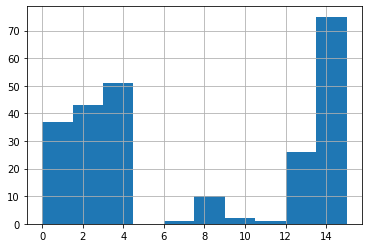

In [ ]:
clusters_fname = f"{sample_path}_clusters.tsv"

# NOTE: when saving embeddings CSV, idx was a regular column (not a pandas 'index').
# When reloaded, 'idx' was made the index column. TODO: make original DF use 'idx' as index,
# so saving and reloading code is identical.
df.to_csv(clusters_fname, index=True, index_label="idx", sep="\t", header=True)

cdf = pd.read_csv(clusters_fname, delimiter="\t", index_col="idx")
cdf.knn_clusterid.hist()

<Axes: >

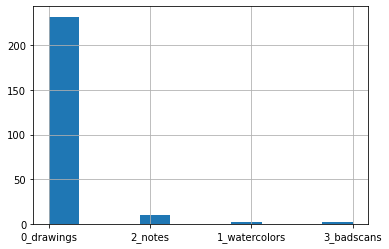

In [ ]:
cdf.knn_label.hist()

## Visualizing Clusters

In [ ]:
#| export
def show_cluster(clusters_df, clusters, idx, colname='orig_fname'):
    imgs = [Image.open(clusters_df.iloc[i][colname]) for i in clusters[idx]]

    fig = plt.figure(figsize=(16.0, 16.0))
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(4, 4),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

In [ ]:
#| export
def show_all_clusters(clusters_df, clusters, cluster_idxs=None, title=None, colname='orig_fname'):
    select_idxs = cluster_idxs if cluster_idxs else range(len(clusters))
    num_clusters = len(select_idxs)
    examples_per_cluster = 16
    fig = plt.figure(figsize=(16.0, float(num_clusters)))
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(num_clusters, examples_per_cluster),
        axes_pad=0.02,
    )
    for row, cluster_idx in enumerate(select_idxs):
        imgs = [
            Image.open(clusters_df.iloc[i][colname]) for i in clusters[cluster_idx]
        ]

        for col, im in enumerate(imgs):
            total_idx = col + row * examples_per_cluster
            ax = grid[total_idx]
            ax.grid = False
            ax.set_xticks([])
            ax.set_yticks([])
            if col == 0:
                ax.set_ylabel(f"{cluster_idx}  ", rotation=0)
            ax.imshow(im)
    if title:
        fig.suptitle(
            title
            if cluster_idxs is None
            else f"{title} (Cluster IDs: {','.join([str(i) for i in select_idxs])})"
        )
    plt.show()

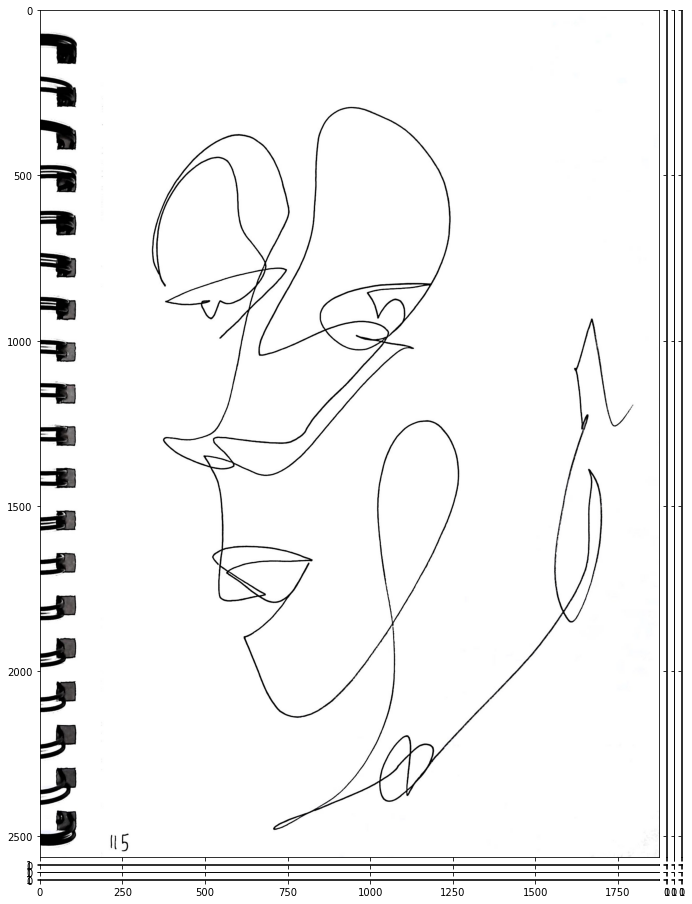

In [ ]:
show_cluster(clusters_df=cdf, clusters=knn_clusterid, idx=14, colname='orig_fname')

In [ ]:
show_all_clusters(clusters_df=cdf, clusters=knn_clusterid)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()

### training
